In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

In [2]:
df_forecast = pd.read_csv('data/forecastdemand_nsw.csv', names = ['id', 'region_id', 'period_id', 'forecast_demand', 'date_time_current', 'date_time_future'], skiprows = 1)
df_forecast.date_time_future = pd.to_datetime(df_forecast.date_time_future, format = "%Y-%m-%d %H:%M:%S")
df_forecast.date_time_current = pd.to_datetime(df_forecast.date_time_current, format = "%Y-%m-%d %H:%M:%S")

In [3]:
def create_forecast_interval(df_forecast, interval, interval_min, interval_max):
    df_forecast_interval = df_forecast.loc[(df_forecast.forecast_interval > interval_min) & (df_forecast.forecast_interval < interval_max)]
    df_forecast_interval["difference_from_interval"] = abs(df_forecast_interval.forecast_interval - interval)
    df_forecast_interval = df_forecast_interval.loc[df_forecast_interval.groupby("date_time_future")["difference_from_interval"].idxmin()]
    df_forecast_interval = df_forecast_interval.rename({"forecast_demand": "forecast_demand_{}h".format(interval)}, axis = 1)
    return df_forecast_interval

#Forecast_interval is the number of hours between prediction and it's forecast (in hours)
df_forecast["forecast_interval"] = df_forecast.date_time_future - df_forecast.date_time_current
df_forecast.forecast_interval = df_forecast.forecast_interval.apply(lambda x: x.total_seconds()/(60*60))

df_forecast_24h = create_forecast_interval(df_forecast, interval = 24, interval_min = 24, interval_max = 25)
df_forecast_18h = create_forecast_interval(df_forecast, interval = 18, interval_min = 18, interval_max = 19)
df_forecast_12h = create_forecast_interval(df_forecast, interval = 12, interval_min = 12, interval_max = 13)
df_forecast_6h = create_forecast_interval(df_forecast, interval = 6, interval_min = 6, interval_max = 6.5)

In [5]:
df_forecast_set_intervals = pd.DataFrame({"date_time_future" : df_forecast.date_time_future.unique()}).sort_values("date_time_future")
df_forecast_set_intervals = pd.merge(df_forecast_set_intervals, df_forecast_24h[["date_time_future", "forecast_demand_24h"]], how = 'left', on = "date_time_future")
df_forecast_set_intervals = pd.merge(df_forecast_set_intervals, df_forecast_18h[["date_time_future", "forecast_demand_18h"]], how = 'left', on = "date_time_future")
df_forecast_set_intervals = pd.merge(df_forecast_set_intervals, df_forecast_12h[["date_time_future", "forecast_demand_12h"]], how = 'left', on = "date_time_future")
df_forecast_set_intervals = pd.merge(df_forecast_set_intervals, df_forecast_6h[["date_time_future", "forecast_demand_6h"]], how = 'left', on = "date_time_future")

intervals_count = len(df_forecast_set_intervals)
print("**Missing Forecasts**\n24h: {}%\n18h: {}%\n12h: {}%\n6h: {}%".format(round(100*df_forecast_set_intervals.forecast_demand_24h.isna().sum()/intervals_count,2),
                                                                            round(100*df_forecast_set_intervals.forecast_demand_18h.isna().sum()/intervals_count,2),
                                                                            round(100*df_forecast_set_intervals.forecast_demand_12h.isna().sum()/intervals_count,2),
                                                                            round(100*df_forecast_set_intervals.forecast_demand_6h.isna().sum()/intervals_count,2)))

**Missing Forecasts**
24h: 35.42%
18h: 10.42%
12h: 0.0%
6h: 0.04%


Observation: similar distributions


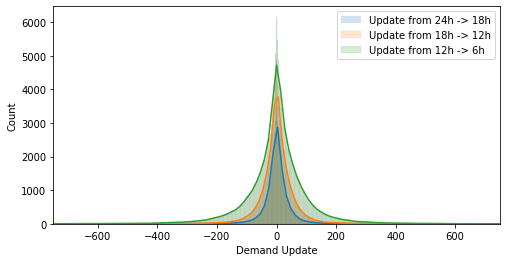

In [14]:
df_forecast_set_intervals_explore = df_forecast_set_intervals.copy()
df_forecast_set_intervals_explore["update_24h_to_18h"] = df_forecast_set_intervals_explore.forecast_demand_18h - df_forecast_set_intervals_explore.forecast_demand_24h
df_forecast_set_intervals_explore["update_18h_to_12h"] = df_forecast_set_intervals_explore.forecast_demand_12h - df_forecast_set_intervals_explore.forecast_demand_18h
df_forecast_set_intervals_explore["update_12h_to_6h"] = df_forecast_set_intervals_explore.forecast_demand_6h - df_forecast_set_intervals_explore.forecast_demand_12h

plt.figure(figsize = (8,4))
sns.histplot(df_forecast_set_intervals_explore.update_24h_to_18h, alpha = 0.2, label = 'Update from 24h -> 18h', kde = True)
sns.histplot(df_forecast_set_intervals_explore.update_18h_to_12h, alpha = 0.2, label = 'Update from 18h -> 12h', kde = True)
sns.histplot(df_forecast_set_intervals_explore.update_12h_to_6h, alpha = 0.2, label = "Update from 12h -> 6h", kde = True)
plt.xlim(-750, 750)
plt.xlabel("Demand Update")
plt.legend()
print("Observation: similar distributions")